Import Of The Important Libraries Required for Solving This Problem.

In [1]:
import os
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline
import string 
import re
from nltk.corpus import stopwords
from collections import Counter
from keras.utils.vis_utils import plot_model
from keras.models import Sequential
from keras.layers import Dense
import pydot
from IPython.display import SVG
from keras.utils.vis_utils import model_to_dot
import graphviz
from keras.preprocessing.text import Tokenizer

Using TensorFlow backend.


In [2]:
os.listdir()

['model.png',
 '.ipynb_checkpoints',
 'negative.txt',
 'Sentiment_Analysis_Udacity.ipynb',
 'txt_sentoken',
 'vocab.txt',
 'review_polarity',
 'positive.txt']

# Preprocessing Step 
# Import Data

In [3]:
# Function to load document into the notebook
def load_document(fileName):
    file=open(fileName,'r')
    text_data=file.read()
    file.close()
    return text_data

In [4]:
# Data Cleaning Step
# Turn a document into tokens after processing it.

def clean_document(document):
    #split the review into tokens by white space
    tokens=document.split()
    # regex for char filtering
    re_punc = re.compile('[%s]' % re.escape(string.punctuation))
    # remove punctuation from each word
    tokens = [re_punc.sub('', w) for w in tokens]
    # removetokens which are not alphabetis
    tokens = [word for word in tokens if word.isalpha()]
    # remove stop words
    ##  A stop word is a commonly used word (such as “the”, “a”, “an”, “in”)
    stop_words = set(stopwords.words('english'))
    tokens = [w for w in tokens if not w in stop_words]
    # remove out short tokens
    tokens = [word for word in tokens if len(word) > 1]
    
    return tokens

In [5]:
filename="txt_sentoken/pos/cv001_18431.txt"
text=load_document(filename)
tokens=clean_document(text)
print(tokens[:10])

['every', 'movie', 'comes', 'along', 'suspect', 'studio', 'every', 'indication', 'stinker', 'everybodys']


In [6]:
# Function to save list to file
def save_list(lines, filename):
    data = '\n'.join(lines)
    file = open(filename, 'w')
    file.write(data)
    file.close()

In [7]:
# load doc, clean and return line of tokens
def doc_to_line(filename, vocab):
    # load the doc
    doc = load_doc(filename)
    # clean doc
    tokens = clean_doc(doc)
    # filter by vocab
    tokens = [w for w in tokens if w in vocab]
    return ' '.join(tokens)

In [8]:
# directory='txt_sentoken/neg'
# for file in os.listdir(directory):
#     if file.endswith(".txt"):
#         doc=load_document(directory+'/'+file)
#         print("Loaded Document %s" % file)

# Develop Vocabulary

In [9]:
# Function to Load Document and then add the words to Vocab
def document_to_vocabulary(fileName,vocab):
    document=load_document(fileName)
    tokens=clean_document(document)
    vocab.update(tokens)

In [10]:
# Function to Process All the documents in the Directory
def process_documents(directory, vocab):
    count=0
    for fileName in os.listdir(directory):
        if fileName.endswith(".txt"):
            path=directory+"/"+fileName
            document_to_vocabulary(path,vocab)
            count+=1
    print("Total Number Of Files Processed In {d} = {n}".format(d=directory,n=count))

In [11]:
# Main Function To Process the documents 
# Global Varaible To Store The Count 

vocab = Counter()

def develop_vocab():
    global vocab
#     vocab= Counter()
    process_documents('txt_sentoken/neg', vocab)
    process_documents('txt_sentoken/pos', vocab)
    
    
    min_occur = 2
    
    tokens = [k for k,c in vocab.items() if c >= min_occur]
    save_list(tokens,"vocab.txt")

develop_vocab()

Total Number Of Files Processed In txt_sentoken/neg = 1000
Total Number Of Files Processed In txt_sentoken/pos = 1000


In [12]:
#Check Whether The File is Create or not 
if "vocab.txt" in os.listdir():
    print("TRUE")

TRUE


In [13]:
#print Length of the Vocabulary
print("Total Length Of The Vocabulary %s" %len(vocab))

Total Length Of The Vocabulary 46557


In [14]:
# 50 Most Common Words
print(vocab.most_common(50))

[('film', 8860), ('one', 5521), ('movie', 5440), ('like', 3553), ('even', 2555), ('good', 2320), ('time', 2283), ('story', 2118), ('films', 2102), ('would', 2042), ('much', 2024), ('also', 1965), ('characters', 1947), ('get', 1921), ('character', 1906), ('two', 1825), ('first', 1768), ('see', 1730), ('well', 1694), ('way', 1668), ('make', 1590), ('really', 1563), ('little', 1491), ('life', 1472), ('plot', 1451), ('people', 1420), ('movies', 1416), ('could', 1395), ('bad', 1374), ('scene', 1373), ('never', 1364), ('best', 1301), ('new', 1277), ('many', 1268), ('doesnt', 1267), ('man', 1266), ('scenes', 1265), ('dont', 1210), ('know', 1207), ('hes', 1150), ('great', 1141), ('another', 1111), ('love', 1089), ('action', 1078), ('go', 1075), ('us', 1065), ('director', 1056), ('something', 1048), ('end', 1047), ('still', 1038)]


# Top Ten Most Common Words

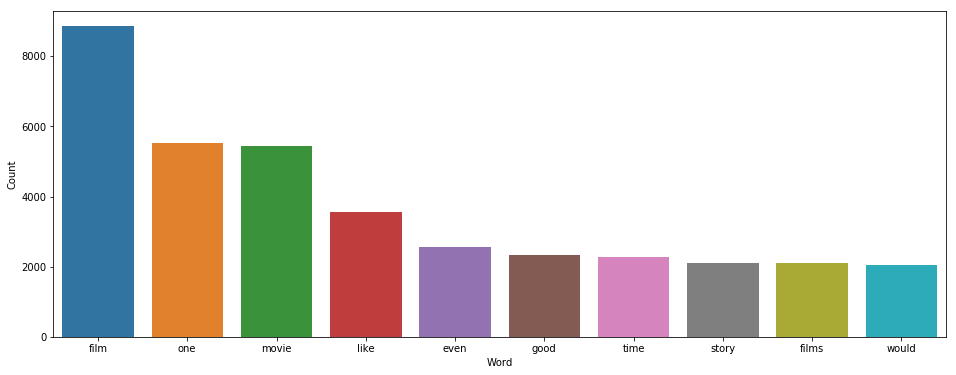

In [15]:
vocabmcdf=pd.DataFrame(data=vocab.most_common(10),columns=['Word','Count'])
plt.figure(figsize=(16,6))
sns.barplot(x='Word',y="Count",data=vocabmcdf)

In [16]:
#Load The Vocabulary from Vocab.txt File.

vocab_data=load_document("vocab.txt")
vocab_data=vocab_data.split()
vocab=set(vocab_data)
print("Number of Words in Vocab.txt is %s" %len(vocab))

Number of Words in Vocab.txt is 27139


# Prepare Review For Modeling

Creating Negative.txt and Positive.txt from all the review documents.

In [17]:
def process_review_documents(directory,vocab,train=False,op=0):
    lines=[]
    count=0
    for file in os.listdir(directory):
#         print(file)

        if file.endswith(".txt"):
            if not op:
                if train and file.startswith("cv9"):
                    continue
                if not train and not file.startswith("cv9"):
                    continue
            count+=1
            file_path=directory + '/' + file
            lines_in_file=load_document(file_path)
            tokens=clean_document(lines_in_file)
            tokens=[w for w in tokens if w in vocab]
            line=' '.join(tokens)
        lines.append(line)
#         print(lines)
    print("Number of File Processed in {d} is {n}".format(d=directory,n=count))
    return lines

# Negative lines from all the documents from "txt_sentoken/neg"

In [18]:
# Negative lines from all the documents from "txt_sentoken/neg"
neg_lines=process_review_documents("txt_sentoken/neg",vocab_data,op=1)
save_list(neg_lines,"negative.txt")

#Load Negative Lines From negative.txt
negative_lines=load_document("negative.txt")
print("Length of the Negative.txt File is %s " %len(negative_lines))


Number of File Processed in txt_sentoken/neg is 1000
Length of the Negative.txt File is 2259871 


In [19]:
print(negative_lines[:100])

studio attracted many weird bizarre people gates wonder film life death studio centers one boring cl


# Positive lines from all the documents from "txt_sentoken/pos"

In [20]:
# Negative lines from all the documents from "txt_sentoken/neg"
pos_lines=process_review_documents("txt_sentoken/pos",vocab_data,op=1)
save_list(pos_lines,"positive.txt")

#Load Negative Lines From negative.txr
positive_lines=load_document("positive.txt")
print("Length of the Positive.txt File is %s " %len(positive_lines))


Number of File Processed in txt_sentoken/pos is 1000
Length of the Positive.txt File is 2564414 


In [21]:
print(positive_lines[:100])

david lynchs blue velvet begins ends colorful bright shots flowers happy americans lawns seemingly p


In [22]:
def load_clean_dataset(vocab,train=False):
    neg=process_review_documents('txt_sentoken/neg', vocab,train)
    pos=process_review_documents('txt_sentoken/pos', vocab,train)
    docs=neg+pos
    print("Length of   Negative Files = {n} \t Positive Files= {p} \t Doc = {d} ".format(n=len(neg),p=len(pos),d=len(docs)))
    labels =[0 for i in range(len(neg))] + [1 for j in range(len(pos))]
    return docs,labels
    

# Train Test Split

Dividing 90% 10% Ration 1000 Review Document

# Load Training DataSet

In [23]:
# load all training reviews
train_docs, ytrain = load_clean_dataset(vocab,train=True)


Number of File Processed in txt_sentoken/neg is 900
Number of File Processed in txt_sentoken/pos is 900
Length of   Negative Files = 900 	 Positive Files= 900 	 Doc = 1800 


In [24]:
print(len(train_docs))

1800


In [25]:
print(len(ytrain))

1800


# Load Test DataSet

In [26]:
test_docs, ytest = load_clean_dataset(vocab)

Number of File Processed in txt_sentoken/neg is 100
Number of File Processed in txt_sentoken/pos is 100
Length of   Negative Files = 100 	 Positive Files= 100 	 Doc = 200 


# Keras Tokenizer To Implement Bag Of Words

In [27]:
# Function To Tokenize
def create_tokenizer(lines):
    tokenizer=Tokenizer()
    tokenizer.fit_on_texts(lines)
    return tokenizer


In [28]:
# create the tokenizer
tokenizer = create_tokenizer(train_docs)

In [29]:
# encode data
Xtrain = tokenizer.texts_to_matrix(train_docs, mode='freq')
Xtest = tokenizer.texts_to_matrix(test_docs, mode='freq')
print(Xtrain.shape, Xtest.shape)

(1800, 26897) (200, 26897)


# Benchmark Model

In [30]:
n_words=Xtest.shape[1]
n_words

26897

In [31]:
# define the model
def define_model(n_words):
    # define network
    model = Sequential()
    model.add(Dense(50, input_shape=(n_words,), activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    # compile network
    model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])
    # summarize defined model
    model.summary()
    plot_model(model, to_file='model.png', show_shapes=True)
    return model

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 50)                1344900   
_________________________________________________________________
dense_2 (Dense)              (None, 1)                 51        
Total params: 1,344,951
Trainable params: 1,344,951
Non-trainable params: 0
_________________________________________________________________
Instructions for updating:
Use tf.cast instead.
Epoch 1/10
 - 2s - loss: 0.6925 - acc: 0.5361
Epoch 2/10
 - 2s - loss: 0.6886 - acc: 0.5006
Epoch 3/10
 - 2s - loss: 0.6800 - acc: 0.6117
Epoch 4/10
 - 2s - loss: 0.6647 - acc: 0.6722
Epoch 5/10
 - 2s - loss: 0.6429 - acc: 0.7994
Epoch 6/10
 - 2s - loss: 0.6173 - acc: 0.8444
Epoch 7/10
 - 2s - loss: 0.5874 - acc: 0.9150
Epoch 8/10
 - 2s - loss: 0.5555 - acc: 0.9372
Epoch 9/10
 - 1s - loss: 0.5228 - acc: 0

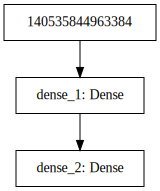

In [35]:
#fit network
model=define_model(n_words)
model.fit(Xtrain, ytrain, epochs=10, verbose=2)


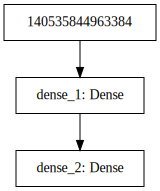

In [37]:
#Plot of The Defined model
SVG(model_to_dot(model).create(prog='dot', format='svg'))

In [36]:
# evaluate
loss, acc  = model.evaluate(Xtest, ytest, verbose=0)
print('Test Loss: %f' % (loss*100))
print('Test Accuracy: %f' % (acc*100))

Test Loss: 55.738977
Test Accuracy: 86.500000


# Compare Word Scoring 

Epoch 1/10
1800/1800 [==============================] - 3s 2ms/step - loss: 0.4548 - acc: 0.8011
Epoch 2/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0497 - acc: 0.9961
Epoch 3/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0147 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 3s 1ms/step - loss: 0.0064 - acc: 1.0000A: 0s - loss: 0.0064 - a
Epoch 5/10
1800/1800 [==============================] - 3s 2ms/step - loss: 0.0035 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0022 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 991us/step - loss: 0.0015 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0011 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 2s 1ms/step - loss: 7.4380e-04 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 0s 461us/step
1 accuracy : 0.93 
Epoch 1/1

Epoch 9/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0012 - acc: 1.0000A: 0s - loss: 0.0011 -
Epoch 10/10
200/200 [==============================] - 0s 795us/step
8 accuracy : 0.93 
Epoch 1/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4719 - acc: 0.7789
Epoch 2/10
1800/1800 [==============================] - 2s 966us/step - loss: 0.0544 - acc: 0.9944
Epoch 3/10
1800/1800 [==============================] - 2s 964us/step - loss: 0.0153 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 2s 971us/step - loss: 0.0073 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 2s 974us/step - loss: 0.0040 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 981us/step - loss: 0.0024 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0016 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0011 - acc: 1.0000
Epoch 9

1800/1800 [==============================] - 2s 904us/step - loss: 0.0038 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 902us/step - loss: 0.0023 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 897us/step - loss: 0.0015 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 897us/step - loss: 0.0010 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 2s 896us/step - loss: 7.5910e-04 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 0s 1ms/step
16 accuracy : 0.92 
Epoch 1/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4899 - acc: 0.7478
Epoch 2/10
1800/1800 [==============================] - 2s 900us/step - loss: 0.0581 - acc: 0.9933
Epoch 3/10
1800/1800 [==============================] - 2s 899us/step - loss: 0.0155 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 2s 895us/step - loss: 0.0078 - acc: 1.0000
Epoch 5/10
1800/1800 [=========

1800/1800 [==============================] - 2s 1ms/step - loss: 0.0595 - acc: 0.9956A: 0s - loss: 0.0615 - acc: 
Epoch 3/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0168 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0084 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0053 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0034 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 3s 1ms/step - loss: 0.0022 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0013 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 3s 1ms/step - loss: 8.5373e-04 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 1s 3ms/step
24 accuracy : 0.915 
Epoch 1/10
1800/1800 [==============================] - 3s 2ms/step - loss: 0.4766 - acc: 0.7883
Epoch 2/10
1800/18

200/200 [==============================] - 0s 2ms/step
31 accuracy : 0.91 
Epoch 1/10
1800/1800 [==============================] - 3s 2ms/step - loss: 0.4611 - acc: 0.7744
Epoch 2/10
1800/1800 [==============================] - 2s 955us/step - loss: 0.0484 - acc: 0.9961
Epoch 3/10
1800/1800 [==============================] - 2s 958us/step - loss: 0.0149 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 2s 961us/step - loss: 0.0072 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 2s 987us/step - loss: 0.0039 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 979us/step - loss: 0.0025 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 954us/step - loss: 0.0017 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 955us/step - loss: 0.0012 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 2s 956us/step - loss: 8.5124e-04 - acc: 1.0000
Epoch 10/10
200/200 [===========

1800/1800 [==============================] - 2s 968us/step - loss: 0.0013 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 975us/step - loss: 8.9877e-04 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 2s 969us/step - loss: 6.7575e-04 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 1s 3ms/step
39 accuracy : 0.935 
Epoch 1/10
1800/1800 [==============================] - 3s 2ms/step - loss: 0.4739 - acc: 0.7783
Epoch 2/10
1800/1800 [==============================] - 2s 959us/step - loss: 0.0582 - acc: 0.9950
Epoch 3/10
1800/1800 [==============================] - 2s 975us/step - loss: 0.0167 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0086 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0052 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0032 - acc: 1.0000
Epoch 7/10
1800/1800 [==========

1800/1800 [==============================] - 2s 1ms/step - loss: 0.0066 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0031 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0018 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0012 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 1ms/step - loss: 8.5309e-04 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 2s 1ms/step - loss: 6.4367e-04 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 1s 3ms/step
7 accuracy : 0.89 
Epoch 1/10
1800/1800 [==============================] - 4s 2ms/step - loss: 0.4661 - acc: 0.7739
Epoch 2/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0581 - acc: 0.9922
Epoch 3/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0153 - acc: 1.0000
Epoch 4/10
1800/1800 [======================

1800/1800 [==============================] - 3s 2ms/step - loss: 0.4621 - acc: 0.7894
Epoch 2/10
1800/1800 [==============================] - 2s 958us/step - loss: 0.0578 - acc: 0.9917
Epoch 3/10
1800/1800 [==============================] - 2s 962us/step - loss: 0.0162 - acc: 0.9994
Epoch 4/10
1800/1800 [==============================] - 2s 954us/step - loss: 0.0069 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 2s 950us/step - loss: 0.0038 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 956us/step - loss: 0.0024 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 952us/step - loss: 0.0017 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 972us/step - loss: 0.0012 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 2s 960us/step - loss: 9.5930e-04 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 1s 4ms/step
15 accuracy : 0.885 
Epoch 1/10
1800/1800 [========

1800/1800 [==============================] - 2s 974us/step - loss: 8.6016e-04 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 1s 4ms/step
22 accuracy : 0.895 
Epoch 1/10
1800/1800 [==============================] - 4s 2ms/step - loss: 0.4501 - acc: 0.7878
Epoch 2/10
1800/1800 [==============================] - 2s 969us/step - loss: 0.0531 - acc: 0.9928
Epoch 3/10
1800/1800 [==============================] - 2s 991us/step - loss: 0.0128 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 2s 992us/step - loss: 0.0057 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 2s 969us/step - loss: 0.0033 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 968us/step - loss: 0.0021 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 973us/step - loss: 0.0014 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 971us/step - loss: 0.0010 - acc: 1.0000
Epoch 9/10
1800/1800 [========

1800/1800 [==============================] - 2s 969us/step - loss: 0.0022 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 965us/step - loss: 0.0013 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 968us/step - loss: 8.7489e-04 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 2s 971us/step - loss: 6.0161e-04 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 1s 5ms/step
30 accuracy : 0.895 
Epoch 1/10
1800/1800 [==============================] - 4s 2ms/step - loss: 0.4493 - acc: 0.7756
Epoch 2/10
1800/1800 [==============================] - 2s 985us/step - loss: 0.0509 - acc: 0.9928
Epoch 3/10
1800/1800 [==============================] - 2s 969us/step - loss: 0.0130 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 2s 967us/step - loss: 0.0062 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 2s 968us/step - loss: 0.0034 - acc: 1.0000
Epoch 6/10
1800/1800 [====

1800/1800 [==============================] - 2s 998us/step - loss: 0.0464 - acc: 0.9950
Epoch 3/10
1800/1800 [==============================] - 2s 995us/step - loss: 0.0124 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 2s 994us/step - loss: 0.0062 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 2s 996us/step - loss: 0.0037 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 994us/step - loss: 0.0025 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0018 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 997us/step - loss: 0.0013 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 2s 998us/step - loss: 9.9951e-04 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 1s 5ms/step
38 accuracy : 0.905 
Epoch 1/10
1800/1800 [==============================] - 4s 2ms/step - loss: 0.4433 - acc: 0.7972
Epoch 2/10
1800/1800 [==========

1800/1800 [==============================] - 2s 1ms/step - loss: 2.9995e-04 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 1s 6ms/step
5 accuracy : 0.885 
Epoch 1/10
1800/1800 [==============================] - 5s 3ms/step - loss: 0.4450 - acc: 0.7861
Epoch 2/10
1800/1800 [==============================] - 2s 996us/step - loss: 0.0116 - acc: 0.9983
Epoch 3/10
1800/1800 [==============================] - 2s 999us/step - loss: 0.0029 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0016 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 2s 996us/step - loss: 0.0011 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 1ms/step - loss: 7.6205e-04 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 988us/step - loss: 5.5090e-04 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 988us/step - loss: 4.1650e-04 - acc: 1.0000
Epoch 9/10
1800/1800 [===

1800/1800 [==============================] - 2s 1ms/step - loss: 0.0012 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 1ms/step - loss: 7.9751e-04 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 1ms/step - loss: 5.7443e-04 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 1ms/step - loss: 4.3170e-04 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 2s 1ms/step - loss: 3.2978e-04 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 1s 7ms/step
13 accuracy : 0.89 
Epoch 1/10
1800/1800 [==============================] - 5s 3ms/step - loss: 0.4566 - acc: 0.7856
Epoch 2/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0130 - acc: 0.9994
Epoch 3/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0036 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0017 - acc: 1.0000
Epoch 5/10
1800/1800 [=============

1800/1800 [==============================] - 5s 3ms/step - loss: 0.4869 - acc: 0.7700
Epoch 2/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0232 - acc: 0.9983
Epoch 3/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0041 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0018 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0012 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 1ms/step - loss: 7.8365e-04 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 1ms/step - loss: 5.7202e-04 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 1ms/step - loss: 4.3266e-04 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 2s 1ms/step - loss: 3.4078e-04 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 1s 7ms/step
21 accuracy : 0.86 
Epoch 1/10
1800/1800 [=============

1800/1800 [==============================] - 2s 864us/step - loss: 4.5011e-04 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 2s 998us/step - loss: 3.4598e-04 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 2s 8ms/step
28 accuracy : 0.89 
Epoch 1/10
1800/1800 [==============================] - 6s 3ms/step - loss: 0.4844 - acc: 0.7689
Epoch 2/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0156 - acc: 1.0000
Epoch 3/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0035 - acc: 1.0000
Epoch 4/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0018 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0011 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 1ms/step - loss: 7.7503e-04 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 1ms/step - loss: 5.6212e-04 - acc: 1.0000
Epoch 8/10
1800/1800 [=========

1800/1800 [==============================] - 2s 1ms/step - loss: 0.0019 - acc: 1.0000
Epoch 5/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0012 - acc: 1.0000
Epoch 6/10
1800/1800 [==============================] - 2s 1ms/step - loss: 8.1489e-04 - acc: 1.0000
Epoch 7/10
1800/1800 [==============================] - 2s 1ms/step - loss: 5.8385e-04 - acc: 1.0000
Epoch 8/10
1800/1800 [==============================] - 2s 1ms/step - loss: 4.3050e-04 - acc: 1.0000
Epoch 9/10
1800/1800 [==============================] - 2s 1ms/step - loss: 3.3120e-04 - acc: 1.0000
Epoch 10/10
200/200 [==============================] - 2s 9ms/step
36 accuracy : 0.845 
Epoch 1/10
1800/1800 [==============================] - 6s 3ms/step - loss: 0.4811 - acc: 0.7739
Epoch 2/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0163 - acc: 0.9983
Epoch 3/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.0038 - acc: 1.0000
Epoch 4/10
1800/1800 [============

1800/1800 [==============================] - 6s 3ms/step - loss: 0.6916 - acc: 0.5511
Epoch 2/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6819 - acc: 0.7350
Epoch 3/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6636 - acc: 0.9139
Epoch 4/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6353 - acc: 0.8872
Epoch 5/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.5989 - acc: 0.9350
Epoch 6/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.5576 - acc: 0.9339
Epoch 7/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.5131 - acc: 0.9483
Epoch 8/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4679 - acc: 0.9544
Epoch 9/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4239 - acc: 0.9600
Epoch 10/10
200/200 [==============================] - 2s 10ms/step
4 accuracy : 0.87 
Epoch 1/10
1800/1800 [=============================

200/200 [==============================] - 2s 10ms/step
11 accuracy : 0.87 
Epoch 1/10
1800/1800 [==============================] - 7s 4ms/step - loss: 0.6917 - acc: 0.5889
Epoch 2/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6819 - acc: 0.7994
Epoch 3/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6615 - acc: 0.8794
Epoch 4/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6302 - acc: 0.9061
Epoch 5/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.5917 - acc: 0.9378
Epoch 6/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.5486 - acc: 0.9411
Epoch 7/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.5010 - acc: 0.9494
Epoch 8/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4575 - acc: 0.9528
Epoch 9/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4131 - acc: 0.9617
Epoch 10/10
200/200 [==============================

1800/1800 [==============================] - 2s 929us/step - loss: 0.5384 - acc: 0.9450
Epoch 9/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.5030 - acc: 0.9506
Epoch 10/10
200/200 [==============================] - 2s 12ms/step
19 accuracy : 0.86 
Epoch 1/10
1800/1800 [==============================] - 7s 4ms/step - loss: 0.6919 - acc: 0.5183
Epoch 2/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6831 - acc: 0.8256
Epoch 3/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6660 - acc: 0.8833
Epoch 4/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6375 - acc: 0.9011
Epoch 5/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.5993 - acc: 0.9022
Epoch 6/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.5538 - acc: 0.9344
Epoch 7/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.5059 - acc: 0.9522
Epoch 8/10
1800/1800 [==========================

1800/1800 [==============================] - 2s 1ms/step - loss: 0.5750 - acc: 0.9344
Epoch 7/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.5338 - acc: 0.9428
Epoch 8/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4898 - acc: 0.9561
Epoch 9/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4477 - acc: 0.9544
Epoch 10/10
200/200 [==============================] - 2s 12ms/step
27 accuracy : 0.865 
Epoch 1/10
1800/1800 [==============================] - 8s 4ms/step - loss: 0.6917 - acc: 0.5006
Epoch 2/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6833 - acc: 0.6761
Epoch 3/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6678 - acc: 0.7278
Epoch 4/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6444 - acc: 0.7506
Epoch 5/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6151 - acc: 0.8606
Epoch 6/10
1800/1800 [===========================

1800/1800 [==============================] - 2s 1ms/step - loss: 0.6396 - acc: 0.8906
Epoch 5/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6042 - acc: 0.9161
Epoch 6/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.5619 - acc: 0.9406
Epoch 7/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.5175 - acc: 0.9511
Epoch 8/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4724 - acc: 0.9572
Epoch 9/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.4287 - acc: 0.9617
Epoch 10/10
200/200 [==============================] - 3s 13ms/step
35 accuracy : 0.86 
Epoch 1/10
1800/1800 [==============================] - 8s 4ms/step - loss: 0.6917 - acc: 0.5778
Epoch 2/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6831 - acc: 0.7489
Epoch 3/10
1800/1800 [==============================] - 2s 1ms/step - loss: 0.6682 - acc: 0.6883
Epoch 4/10
1800/1800 [============================

NameError: name 'pyplot' is not defined

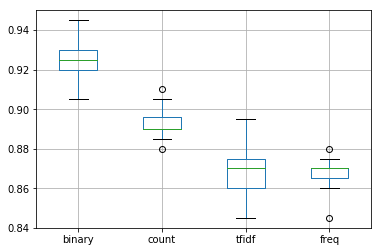

In [47]:

modes= ['binary', 'count', 'tfidf', 'freq']
#Prepare Bag - Of - Words Encoding
results=pd.DataFrame()
def prepare_data(train,test,m):
    token=Tokenizer()
    token.fit_on_texts(train)
    Xtrain=token.texts_to_matrix(train, mode=mode)
    Xtest = token.texts_to_matrix(test, mode=mode)
    return Xtrain,Xtest

#Evaluate
def evaluate_mode(Xtrain,ytrain,Xtest,ytest):
    scores=list()
    no_r=40
    for _ in range(no_r):
        model=Sequential() 
        model.add(Dense(50,input_shape=(n_words,),activation='relu'))
        model.add(Dense(1,activation='sigmoid'))
        model.compile(loss='binary_crossentropy',optimizer='adam',metrics=['accuracy'])
        model.fit(Xtrain,ytrain,epochs=10,verbose=1)
        loss,acc=model.evaluate(Xtest,ytest,verbose=1)
        scores.append(acc)
        print("%d accuracy : %s "%((_+1),acc))
    return scores

for mode in modes:
    Xtrain, Xtest = prepare_data(train_docs, test_docs, mode)
    results[mode] = evaluate_mode(Xtrain, ytrain, Xtest, ytest)



          binary      count      tfidf       freq
count  40.000000  40.000000  40.000000  40.000000
mean    0.923125   0.893000   0.868125   0.867500
std     0.007653   0.006284   0.012944   0.006504
min     0.905000   0.880000   0.845000   0.845000
25%     0.920000   0.890000   0.860000   0.865000
50%     0.925000   0.890000   0.870000   0.870000
75%     0.930000   0.896250   0.875000   0.870000
max     0.945000   0.910000   0.895000   0.880000


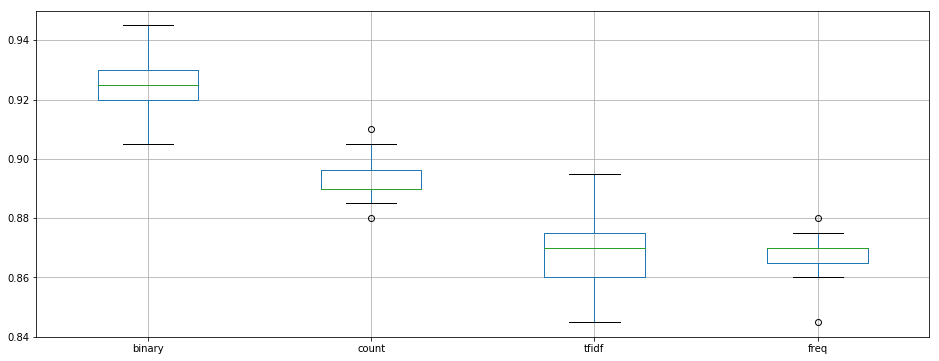

In [50]:
print(results.describe())
plt.figure(figsize=(16,6))
results.boxplot()
plt.show()
